In [62]:
import os

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/paper/01.01_GPR_HOMO_QM9_constantkernel_hyperoptim_rdkit/"
output_figures_path = os.environ["FIGURES"] + "/07_BBO/02_models/paper/01.01_GPR_HOMO_QM9_constantkernel_hyperoptim_rdkit/"

# dft_path = os.environ["DFT_COMPUT_RDKIT_MM"]

N_MOL = 3000

CV_INTERNAL = 5
CV_EXTERNAL = 10

N_JOBS=55

ALPHAS = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

MM_program = "rdkit"

models_to_run = [
    ("1.0*SOAP( xi=2)", "SOAP"),
    ("1.0*RBF( 1.0)", "MBTR"),
    ("1.0*DotProduct( sigma_0=1)", "MBTR"),
    ("1.0*DotProduct( sigma_0=1)", "Shingles count")
]

dft_path = "/tmp"

In [63]:
from bbo.objective import EvoMolEvaluationStrategyWrapper
from evomol.evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path=dft_path,
                          MM_program=MM_program))

133798 molecules in cache


In [64]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)
makedirs(output_figures_path, exist_ok=True)

In [65]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        K = (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
        
        if np.sum(np.isinf(K)) > 0:
            print("Inf values in kernel")
            
        if np.sum(np.isnan(K)) > 0:
            print("Nan values in kernel")
        
        # Replacing possible nan values due to zero by zero division
        K[np.isnan(K)] = 0
        
        if eval_gradient:
            return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K
    

    def get_params(self, deep=True):
        return {"xi": self.xi}
    
    def __repr__(self):
        return "{0}(xi={1:.3g})".format(self.__class__.__name__, self.xi)


In [66]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("1.0*RBF( 1.0)", 1.0*RBF(1.0)),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1)),
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2))]


models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1],
                                                       optimizer="fmin_l_bfgs_b")))


In [67]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors_mm = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=N_JOBS, average="inner", rcut=4, nmax=5, 
                      lmax=6, species=["C", "H", "O", "N", "F"], MM_program=MM_program)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program=MM_program)), 
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)),
    ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=N_JOBS, MM_program=MM_program)),
]
    

In [69]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success, comput_times = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

In [70]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from os.path import join
import json

def procedure(models, descriptors, objective, dataset_path, output_path, geometry_type, preprocessing=None):
    
    # Extracting required number of SMILES
    smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:N_MOL]:
            smiles_list.append(smi.rstrip())
            
    # Iteration over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, desc_builder = descriptor_tuple
                
        # Computing descriptors and objective values for current descriptor 
        X, y, smiles_list_filtered = compute_desc_obj(smiles_list, desc_builder, objective)
        
        # Iteration over all models
        for model_tuple in models:
            
            model_name, model = model_tuple
            
            # Checking that experiment must be run
            if (model_name, desc_name) in models_to_run:
            
                experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type
                experiment_output_json = join(output_path, experiment_name + ".json")


                if preprocessing is not None:
                    pipeline = Pipeline([
                        ("Preprocessing", preprocessing),
                        ("model", model)
                    ])
                else:
                    pipeline = Pipeline([
                        ("model", model)
                    ])

                param_grid = {"alpha": ALPHAS}
                
                scoring = {
                    "MAE": "neg_mean_absolute_error",
                    "RMSE": "neg_root_mean_squared_error"
                }

                # Declaring grid search object (internal CV)
                grid_search_reg = GridSearchCV(estimator=model, param_grid=param_grid, 
                                               scoring=scoring, n_jobs=int(N_JOBS),
                                               cv=CV_INTERNAL, verbose=3, refit="MAE")

                # Performing cross validation (external CV)
                scores = cross_validate(estimator=grid_search_reg, X=X, y=y, scoring=scoring,
                                        cv=CV_EXTERNAL, n_jobs=1, verbose=3, return_estimator=True)

                print(scores)

                # Computing output dictionary
                output_dict = {
                    "exp_name": experiment_name,
                    "mean_mae": float(- scores["test_MAE"].mean()),
                    "mae_values": (- scores["test_MAE"]).tolist(),
                    "mean_rmse": float(- scores["test_RMSE"].mean()),
                    "rmse_values": (- scores["test_RMSE"]).tolist(),
                    "best_alphas": [float(scores["estimator"][i].best_params_["alpha"]) for i in range(CV_EXTERNAL)],
                    "mean_refit_time": float(np.array([scores["estimator"][i].refit_time_ for i in range(CV_EXTERNAL)]).mean()),
                    "refit_times": [float(scores["estimator"][i].refit_time_) for i in range(CV_EXTERNAL)] 
                }

                # Writing output json file to disk
                with open(experiment_output_json, "w") as f:
                    json.dump(output_dict, f, indent=4)

# Performing experiments

## MM geometry

### No preprocessing

In [71]:
# procedure(models, descriptors_mm, objective, dataset_path, output_results_path, geometry_type="MM", 
#          preprocessing=None)

In [72]:
import time

def compute_descriptors_times(descriptors, geometry_type):
    
    # Extracting required number of SMILES
    smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:N_MOL]:
            smiles_list.append(smi.rstrip())
    
    # Iterating over all descriptors
    for descriptor in descriptors:
        
        desc_name, desc_instance = descriptor
        
        print(desc_name)
        
        # Setting n_jobs to 1
        desc_instance.n_jobs = 1
        
        # Computing descriptors and recording computation time on a single thread
        tstart = time.time()
        desc_instance.fit_transform(smiles_list)
        comput_time = time.time() - tstart
        
        # Computing experiment name
        experiment_name = desc_name + "-" + geometry_type
        experiment_output_file = join(output_results_path, experiment_name + ".txt")
        
        with open(experiment_output_file, "w") as f:
            f.writelines([str(comput_time)])

# Computing descriptors times 

In [73]:
# compute_descriptors_times(descriptors_mm, geometry_type="MM")

In [113]:
import json
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)


def init_results_dict(models, descriptors):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    

def extract_results(json_path):
    
    with open(json_path, "r") as f:
        json_dict = json.load(f)
        
        mean_mae = json_dict["mean_mae"]
        mae_values = json_dict["mae_values"]
        mean_rmse = json_dict["mean_rmse"]
        rmse_values = json_dict["rmse_values"]
        best_alphas = json_dict["best_alphas"]
        mean_refit_time = json_dict["mean_refit_time"]
        refit_times = json_dict["refit_times"]
        
    return mean_mae, mae_values, mean_rmse, rmse_values, best_alphas, mean_refit_time, refit_times

def extract_time(descriptor, geometry_type):
    
    desc_name, _ = descriptor
    path = join(output_results_path, desc_name + "-" + geometry_type + ".txt")
    
    with open(path, "r") as f:
        return(float(f.readline()))
    
def desc_kernel_to_model_name(desc_name, kernel_name):
    
    if key == "Shingles count":
        desc = "Shingles"
    else:
        desc = key

    if all_kernels[j] == "1.0*SOAP( xi=2)":
        kernel = "SOAP"
    elif all_kernels[j] == "1.0*RBF( 1.0)":
        kernel = "RBF"
    elif all_kernels[j] == "1.0*DotProduct( sigma_0=1)":
        kernel = "·"
    
    return "("+desc+"," + kernel +")"
    
def plot_values_subplot(error_dict, time_dict, error_name):
    
    plt.xlim((0.2, 0.4))
    plt.ylim((1, 10000))
    plt.xlabel(error_name + " (eV)")
    plt.ylabel("time (s)")
    plt.yscale("log")    

    colors = sns.color_palette()
    markers = ['s', '^', 'o', '+', 'x']
    
    all_kernels = list(error_dict["kernel"])
    all_desc = []
    for i, key in enumerate(error_dict.keys()):
        
        if key != "kernel":
            
            all_desc.append(key)
            
            for j in range(len(kernels)):
                
                if (all_kernels[j], key) in models_to_run:
                    
                    model_name = desc_kernel_to_model_name(key, all_kernels[j])
                
                    plt.scatter(error_dict[key][j], time_dict[key][j], label=model_name)
    
def plot_time_vs_error(mae_dict, rmse_dict, time_fit_dict, time_fit_plus_desc_dict, geometry_type, preprocessing):
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 2, 1)
    plot_values_subplot(mae_dict, time_fit_dict, "MAE")
    plt.subplot(2, 2, 2)
    plot_values_subplot(mae_dict, time_fit_plus_desc_dict, "MAE")
    plt.subplot(2, 2, 3)
    plot_values_subplot(rmse_dict, time_fit_dict, "RMSE")
    plt.subplot(2, 2, 4)
    plot_values_subplot(rmse_dict, time_fit_plus_desc_dict, "RMSE")

    plt.legend()
    plt.savefig(join(output_figures_path, "time_vs_mae-" + geometry_type + "-" + preprocessing +".png"), dpi=300)
    plt.show()

    
    

def display_results(models, descriptors, objective, results_root, geometry_type, preprocessing):
    
    MAE_output_dict = init_results_dict(models, descriptors)
    RMSE_output_dict = init_results_dict(models, descriptors)
    mean_refit_time_dict = init_results_dict(models, descriptors)
    mean_refit_time_plus_desc_comput_dict = init_results_dict(models, descriptors)
    mean_refit_time_plus_desc_comput_dict_div = init_results_dict(models, descriptors)
    best_alphas_dict = init_results_dict(models, descriptors)
    
    # Iterating over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, _ = descriptor_tuple
        
        desc_comput_time = extract_time(descriptor_tuple, geometry_type)
        
        # Iterating over all models
        for model_tuple in models:
            
            model_name, model = model_tuple
            
            if (model_name, desc_name) in models_to_run:
            
                # Computing model name and path
                experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type
                experiment_json_path = join(results_root, experiment_name + ".json")

                # Extracting data from disk
                mean_mae, mae_values, mean_rmse, rmse_values, best_alphas, mean_refit_time,\
                    refit_times = extract_results(experiment_json_path)

                MAE_output_dict[desc_name].append(mean_mae)
                RMSE_output_dict[desc_name].append(mean_rmse)
                mean_refit_time_dict[desc_name].append(mean_refit_time)
                mean_refit_time_plus_desc_comput_dict[desc_name].append(mean_refit_time + desc_comput_time)
                mean_refit_time_plus_desc_comput_dict_div[desc_name].append(mean_refit_time + desc_comput_time/300)
                best_alphas_dict[desc_name].append(str(best_alphas))            
                
            else:
                
                MAE_output_dict[desc_name].append(None)
                RMSE_output_dict[desc_name].append(None)
                mean_refit_time_dict[desc_name].append(None)
                mean_refit_time_plus_desc_comput_dict[desc_name].append(None)
                mean_refit_time_plus_desc_comput_dict_div[desc_name].append(None)
                best_alphas_dict[desc_name].append(None)            
    
    display_dict("MAE", MAE_output_dict)
    display_dict("RMSE", RMSE_output_dict)
    display_dict("Mean time fit", mean_refit_time_dict)
    display_dict("Mean time fit + MM/desc comput time", mean_refit_time_plus_desc_comput_dict)
    display_dict("Mean time fit + (MM/desc comput time)/300", mean_refit_time_plus_desc_comput_dict_div)
    
    plot_time_vs_error(MAE_output_dict, RMSE_output_dict, mean_refit_time_dict, mean_refit_time_plus_desc_comput_dict, 
                     geometry_type, str(preprocessing))


    display_dict("Selected alpha values", best_alphas_dict)
    

# MM results 


## No preprocessing

kernel      SOAP      MBTR  Shingles count    CM
0               1.0*RBF( 1.0)       NaN  0.210277             NaN  None
1  1.0*DotProduct( sigma_0=1)       NaN  0.220585        0.215675  None
2             1.0*SOAP( xi=2)  0.249623       NaN             NaN  None

kernel      SOAP      MBTR  Shingles count    CM
0               1.0*RBF( 1.0)       NaN  0.268584             NaN  None
1  1.0*DotProduct( sigma_0=1)       NaN  0.287717        0.279188  None
2             1.0*SOAP( xi=2)  0.323206       NaN             NaN  None

kernel      SOAP        MBTR  Shingles count    CM
0               1.0*RBF( 1.0)       NaN  226.054146             NaN  None
1  1.0*DotProduct( sigma_0=1)       NaN   20.693477       65.666848  None
2             1.0*SOAP( xi=2)  52.27375         NaN             NaN  None

kernel         SOAP         MBTR  Shingles count    CM
0               1.0*RBF( 1.0)          NaN  1310.879632             NaN  None
1  1.0*DotProduct( sigma_0=1)          NaN  1105.518963       94.292146  None
2             1.0*SOAP( xi=2)  1031.702244          NaN             NaN  None

kernel       SOAP        MBTR  Shingles count    CM
0               1.0*RBF( 1.0)        NaN  229.670231             NaN  None
1  1.0*DotProduct( sigma_0=1)        NaN   24.309562       65.762265  None
2             1.0*SOAP( xi=2)  55.538512         NaN             NaN  None

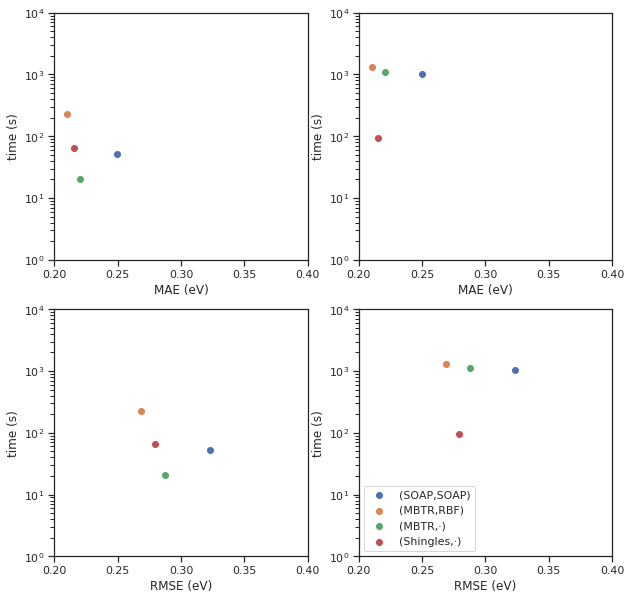

kernel  \
0               1.0*RBF( 1.0)   
1  1.0*DotProduct( sigma_0=1)   
2             1.0*SOAP( xi=2)   

                                                SOAP  \
0                                               None   
1                                               None   
2  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   

                                                MBTR  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
2                                               None   

                                      Shingles count    CM  
0                                               None  None  
1  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...  None  
2                                               None  None

In [114]:
display_results(models, descriptors_mm, objective, output_results_path, geometry_type="MM", preprocessing=None)